# Синтетика

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
from scipy.integrate import solve_ivp
from scipy.integrate import simps

In [4]:
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'Liberation Sans',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

In [5]:
def plot_x_y(x, y, x_label="x", y_label="y"):
    fig = plt.figure()
    ax = fig.gca()
    fig.set_figheight(8)
    fig.set_figwidth(16)
    ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
    ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')
    
    ax.plot(x, y)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

In [6]:
import sys
sys.path.insert(0, './python')

In [7]:
from windkessel import model, utils, synthetic

In [8]:
import re
from os import listdir

filenames = listdir("./data")
IDs = [int(filename[0:-4]) for filename in filenames if re.match(r".*\.csv$", filename)]

## Синтетическое $ Q_{in} $

In [9]:
synhetic_artery = synthetic.SyntheticArtery()
synhetic_artery.R_f = 0.3

In [10]:
T = np.linspace(0.0, synhetic_artery.T, 100)
synthetic_Q_in = np.array([synhetic_artery.get_Q_in(t) for t in T])

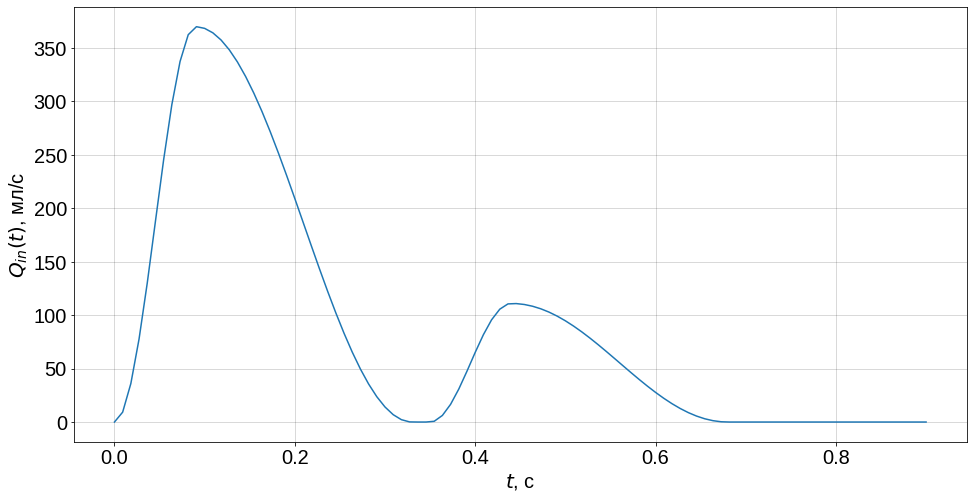

In [11]:
plot_x_y(T, synthetic_Q_in, "$ t $, с", "$ Q_{in}(t) $, мл/с")

## Получение $ P(t) $ по синтетическому $ Q_{in}(t) $

In [12]:
windkessel_model = model.WindkesselModel()
windkessel_model.set_Q_in(T, synthetic_Q_in)

In [13]:
n_cycles = 5
new_T = np.linspace(T[0], T[0] + n_cycles * (T[-1] - T[0]), n_cycles * (T.shape[0] - 1) + 1)

In [14]:
n_steps_per_cycle = 100
max_dt = (T[-1] - T[0]) / n_steps_per_cycle

In [15]:
result = solve_ivp(lambda t, P : windkessel_model.P_rhs(t, P), (new_T[0], new_T[-1]), np.array([66.0]),
                   t_eval=new_T, max_step=max_dt, rtol=1.0)

In [16]:
synthetic_P = result.y[0]

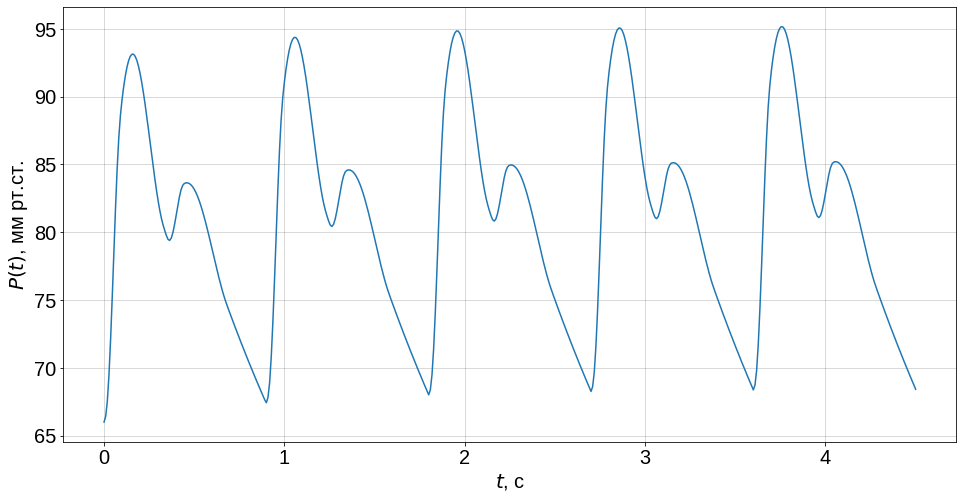

In [17]:
plot_x_y(new_T, synthetic_P, "$ t $, с", "$ P(t) $, мм рт.ст.")

## Подгонка под реальный профиль

In [18]:
def P_functional(x, T, P, plot=False):
    """
    Функционал невязки между заданным и синтетическим P.
    """
    
    # Сдвиг временной сетки в нулевую точку.
    T = T - T[0]
    
    # Модель windkessel.
    windkessel_model = model.WindkesselModel()
    windkessel_model.set_P(T, P)
    
    # Генератор синтетических данных.
    synhetic_artery = synthetic.SyntheticArtery()
    
    # Задание параметров.
    synhetic_artery.T_max, synhetic_artery.T_s, synhetic_artery.T_d, \
            synhetic_artery.Q_max, synhetic_artery.R_f, windkessel_model.R, \
            windkessel_model.Z_0, windkessel_model.C, windkessel_model.P_out = x
    synhetic_artery.T = T[-1]
            
    # Синтетическое Q_in(t).
    synthetic_Q_in = np.array([synhetic_artery.get_Q_in(t) for t in T])
    windkessel_model.set_Q_in(T, synthetic_Q_in)
    
    # Синтетическое P(t).
    n_steps = 100
    max_dt = (T[-1] - T[0]) / n_steps
    result = solve_ivp(lambda t, p : windkessel_model.P_rhs(t, p), (T[0], T[-1]), np.array([P[0]]),
                   t_eval=T, max_step=max_dt, rtol=1.0)
    
    synthetic_P = result.y[0]
    
    if plot:
        # Q(t)
        plot_x_y(T, synthetic_Q_in, "$ t $, с", "$ Q_{in}(t) $, мл/с")
        
        # P(t)
        fig = plt.figure()
        ax = fig.gca()
        fig.set_figheight(8)
        fig.set_figwidth(16)
        ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
        ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')

        ax.plot(T, P, label="Измерение")
        ax.plot(T, synthetic_P, label="Синтетика")

        ax.set_xlabel("$ t $, с")
        ax.set_ylabel("$ P(t) $, мм рт. ст.")
        
        ax.legend(loc="upper right")
    
    value = np.sqrt(simps((P - synthetic_P)**2, T))
    return value

### Проверка на пациенте

In [19]:
patient_id = 144237

In [20]:
def get_T_P_from_patient_id(patient_id):
    tp = pd.read_csv(f'data/{patient_id}.csv', header = None, sep = ' ')
    
    # t в секундах, p в мм.рт.ст.
    tp = tp.rename({0 :'t', 1: 'p'}, axis = 1)
    tp = tp.sort_values(by=['t'])
    
    #Из эксперимента
    T = np.array(tp['t'])
    P = np.array(tp['p'])
    
    return T, P

In [21]:
T, P = get_T_P_from_patient_id(patient_id)

In [22]:
# Фильтрация.
n_points = 200
interp1d_params = {}
savgol_filter_params = {"window_length": 9, "polyorder": 3, "mode": "nearest"}

T, P = utils.nonuniform_savgol_filter(T, P, n_points=n_points,
        interp1d_params=interp1d_params, savgol_filter_params=savgol_filter_params)

In [23]:
windkessel_model.set_P(T, P)

In [24]:
result = windkessel_model.get_synthetic_artery_params()

1.0214084165854487

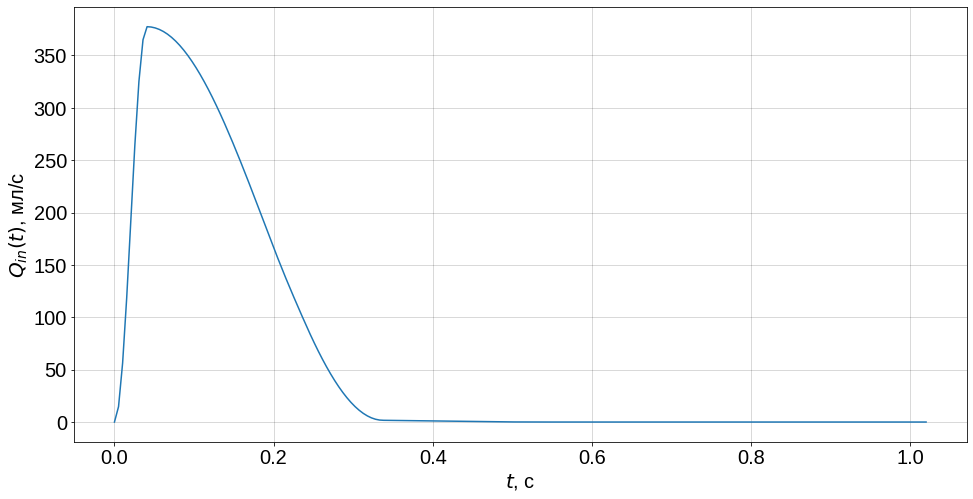

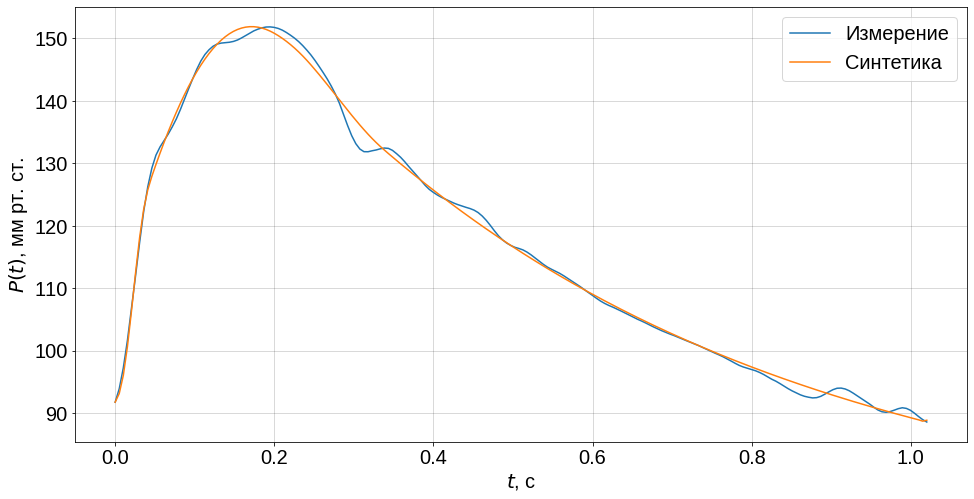

In [25]:
P_functional(result.x, T, P, plot=True)

In [26]:
print("Подобранные параметры: ")
print("T_max, с: \t\t\t%.2f"             % result.x[0])
print("T_s, с: \t\t\t%.2f"               % result.x[1])
print("T_d, с: \t\t\t%.2f"               % result.x[2])
print("Q_max, мл/с: \t\t\t%.2f"          % result.x[3])
print("R_f: \t\t\t\t%.2f"                % result.x[4])
print("R, мм рт. ст. * с / мл: \t%.2f"   % result.x[5])
print("Z_0, мм рт. ст. * с / мл: \t%.2f" % result.x[6])
print("C, мл / мм рт. ст.: \t\t%.2f"     % result.x[7])
print("P_out, мм рт. ст.: \t\t%.2f"      % result.x[8])

Подобранные параметры: 
T_max, с: 			0.04
T_s, с: 			0.34
T_d, с: 			0.20
Q_max, мл/с: 			377.40
R_f: 				0.01
R, мм рт. ст. * с / мл: 	0.64
Z_0, мм рт. ст. * с / мл: 	0.07
C, мл / мм рт. ст.: 		0.87
P_out, мм рт. ст.: 		70.39


In [27]:
windkessel_model.R     = result.x[5]
windkessel_model.Z_0   = result.x[6]
windkessel_model.C     = result.x[7]
windkessel_model.P_out = result.x[8]

In [28]:
windkessel_model.set_P(T, P)
result_ivp = solve_ivp(lambda t, q : windkessel_model.Q_in_rhs(t, q), (T[0], T[-1]), np.array([0.0]),
                       t_eval=T, max_step=max_dt, rtol=1.0)

In [29]:
Q_in = result_ivp.y[0]

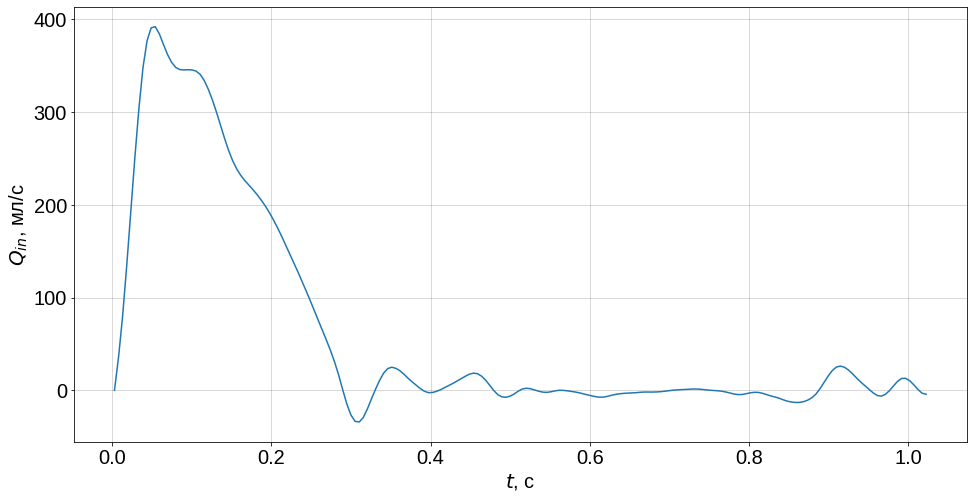

In [30]:
plot_x_y(T, Q_in, "$ t $, с", "$ Q_{in} $, мл/с")